In [1]:
%%capture
## Latex Plot
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

# Problem formulation

In [2]:
# %%capture
# !pip install gurobipy

In [3]:
# %%capture
# !pip install pennylane

## Graphlet Function

In [4]:
import random

def graphleting(num_nodes, graphlet_size=4, overlap_nodes=1):
    graphlet_indices = []  # Store the indices of nodes in each graphlet

    # Generate indices for overlapping partitions
    indices = list(range(num_nodes))
    random.shuffle(indices)  # Shuffle nodes (optional)

    i = 0
    while i < num_nodes - (graphlet_size - 1):
        sub_indices = indices[i:i + graphlet_size]  # Select nodes for this graphlet
        graphlet_indices.append(sub_indices)  # Store node indices

        # Move forward while keeping overlap
        i += (graphlet_size - overlap_nodes)

    return graphlet_indices  # Return indices too

def star_subgraph(adjacency_matrix, subgraph_size=4):
    num_nodes = adjacency_matrix.shape[0]
    subgraph_indices = []
    uncovered_neighbors = set(range(num_nodes))  # all nodes need to be neighbors at least once

    for center_node in range(num_nodes):
        neighbors = [i for i in range(num_nodes) if adjacency_matrix[center_node, i] != 0 and i != center_node]
        k = subgraph_size - 1

        # Remove center node from candidates
        candidates = [n for n in neighbors if n != center_node]

        # First try to cover uncovered nodes
        available_new = list(set(candidates) & uncovered_neighbors)

        if len(available_new) >= k:
            sampled_neighbors = random.sample(available_new, k)
        else:
            # Use uncovered + random fill
            sampled_neighbors = available_new
            remaining_k = k - len(available_new)
            remaining_pool = list(set(candidates) - set(sampled_neighbors))
            sampled_neighbors += random.sample(remaining_pool, remaining_k) if remaining_pool else []

        # Update uncovered list
        uncovered_neighbors -= set(sampled_neighbors)

        subgraph = [center_node] + sampled_neighbors
        subgraph_indices.append(subgraph)

    return subgraph_indices

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_star_subgraphs(adjacency_matrix, subgraph_list, num_to_plot=5, layout='spring'):
    """
    Visualize star-shaped subgraphs (only center ↔ neighbors edges).

    Args:
        adjacency_matrix: [N x N] full adjacency matrix (numpy or torch)
        subgraph_list: list of [center, neighbor1, ..., neighbor_k]
        num_to_plot: how many subgraphs to visualize
        layout: 'spring', 'circular', or 'kamada_kawai'
    """
    if hasattr(adjacency_matrix, 'numpy'):
        adjacency_matrix = adjacency_matrix.numpy()

    plt.figure(figsize=(5 * num_to_plot, 5))

    for idx, sub_nodes in enumerate(subgraph_list[:num_to_plot]):
        plt.subplot(1, num_to_plot, idx + 1)

        center = sub_nodes[0]
        neighbors = sub_nodes[1:]

        # Create a new STAR graph manually
        G_star = nx.Graph()
        G_star.add_node(center)
        for n in neighbors:
            G_star.add_edge(center, n)

        # Layout
        if layout == 'spring':
            pos = nx.spring_layout(G_star, seed=42)
        elif layout == 'circular':
            pos = nx.circular_layout(G_star)
        else:
            pos = nx.kamada_kawai_layout(G_star)

        # Color center differently
        node_colors = ['tomato' if node == center else 'skyblue' for node in G_star.nodes]

        nx.draw(G_star, pos, with_labels=True, node_color=node_colors, edge_color='gray',
                node_size=800, font_size=10)
        plt.title(f"Star Subgraph {idx + 1} (center: {center})")

    plt.tight_layout()
    plt.show()


In [6]:
# adj = torch.randint(0, 2, (20, 20))  # random adjacency matrix for testing
# # Example with fully connected adjacency matrix
# adj = torch.ones(20, 20) - torch.eye(20)  # fully connected, no self-loops

# subs = star_subgraph(adj, subgraph_size=5)
# visualize_star_subgraphs(adj, subs, num_to_plot=5)


In [7]:
import numpy

# # Parameters
# N = 4  # Number of UEs
# p = 5  # Transmit power of each UE
# I0 = 0.5  # Interference to all UEs
# n0 = 1  # Noise power

# # Random channel gains (h_n) for each UE
# h = np.random.rand(N)

In [8]:
def calculate_sum_SINR(alpha, h, p, I0, n0):
    sum_SINR = 0
    N = len(h)
    for n in range(N):
        # Calculate interference for user n
        interference_n = numpy.sum([alpha[i] * I0 for i in range(N) if i != n])
        SINR_n = p * alpha[n] * h[n] / (interference_n + n0)
        sum_SINR += SINR_n
    return sum_SINR


## Exhaustive Search

In [9]:
import itertools

# # Exhaustive search: generate all possible combinations of alpha
# best_alpha = None
# best_sum_SINR = -np.inf  # Initialize with a very low value

# # Iterate over all 2^N possible combinations of alpha (binary values)
# all_sum_rate = []
# for alpha_combination in itertools.product([0, 1], repeat=N):
#     alpha = np.array(alpha_combination)  # Convert tuple to array
#     sum_SINR = calculate_sum_SINR(alpha, h, p, I0, n0)
#     all_sum_rate.append(sum_SINR)
#     # Update the best solution if this combination gives a higher sum SINR
#     if sum_SINR > best_sum_SINR:
#         best_sum_SINR = sum_SINR
#         best_alpha = alpha

# # Output the optimal solution
# print("Optimal alpha:", best_alpha)
# print("Optimal sum of SINR:", best_sum_SINR)


In [10]:
def exhaustive_search_best_alpha(N, h, p, I0, n0):
    best_alpha = None
    best_sum_SINR = -numpy.inf  # Initialize with a very low value

    for alpha_combination in itertools.product([0, 1], repeat=N):
        alpha = numpy.array(alpha_combination)
        sum_SINR = calculate_sum_SINR(alpha, h, p, I0, n0)

        if sum_SINR > best_sum_SINR:
            best_sum_SINR = sum_SINR
            best_alpha = alpha

    return best_alpha, best_sum_SINR

## Create Dataset

In [11]:
# Parameters
N = 5  # Number of UEs
p = 10  # Transmit power of each UE
I0 = 0.5  # Interference to all UEs
n0 = 1  # Noise power

# Random channel gains (h_n) for each UE
h = numpy.random.rand(N)

best_a, best_s = exhaustive_search_best_alpha(N, h, p, I0, n0)
print(best_a, best_s)

[0 1 0 1 1] 12.37435892221091


## Fractional Programming

In [12]:
def calculate_lambda(alpha, h, p, I0, n0):
    N = h.shape[0]
    lambda_vals = numpy.zeros(N)
    for n in range(N):
        interference_n = numpy.sum([alpha[i] * I0 for i in range(N) if i != n])
        lambda_vals[n] = numpy.sqrt(h[n] * p * alpha[n]) / (interference_n + n0)
    return lambda_vals

In [13]:
def recalculate_objective(alpha, lambda_vals, h, p, I0, n0):
    obj_value = 0
    for n in range(N):
        interference = numpy.sum([alpha[i] * I0 for i in range(N) if i != n])
        obj_value += (2 * lambda_vals[n] * numpy.sqrt(alpha[n] * h[n] * p) - lambda_vals[n] ** 2 * (interference + n0))
    return obj_value

In [14]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB


num_random_restarts = 10  # Number of times to try with different random initializations

best_alpha = None
best_objVal = -numpy.inf

for restart in range(num_random_restarts):

    max_iter = 100
    epsilon = 1e-10
    sum_SINR_list = []
    # Step 1: Init value
    # alpha = np.ones(N)
    alpha = numpy.random.randint(0, 2, N)
    lambda_vals = calculate_lambda(alpha, h, p, I0, n0)
    objVal_old = numpy.inf
    # Iteration loop
    for iteration in range(max_iter):

        # Step 2: Solve optimization problem with Gurobi
        model = gp.Model("SINR_Optimization")
        model.setParam('OutputFlag', 0)
        model.setParam('OptimalityTol', 1e-9)  # Tighten optimality tolerance
        model.setParam('FeasibilityTol', 1e-9)  # Tighten feasibility tolerance
        alpha_vars = model.addVars(N, vtype=GRB.BINARY, name="alpha")

        # Add continuous auxiliary variables y_n
        y_vars = model.addVars(N, lb=0, name="y")

        # Add continuous variables z_n to represent sqrt(alpha_n)
        z_vars = model.addVars(N, lb=0, name="z")

        for n in range(N):
            model.addGenConstrPow(z_vars[n], alpha_vars[n], 0.5, name=f"sqrt_constr_{n}")

        objective = gp.LinExpr()
        for n in range(N):
            objective += (2 * lambda_vals[n] * alpha_vars[n] * numpy.sqrt(p * h[n])
            - lambda_vals[n] ** 2 * (gp.quicksum(alpha_vars[i] * I0 for i in range(N) if i != n) + n0))

        model.setObjective(objective, GRB.MAXIMIZE)
        model.optimize()

        # Step 3: Get optimized values
        alpha_new = numpy.array([alpha_vars[n].X for n in range(N)])
        lambda_vals_new = calculate_lambda(alpha_new, h, p, I0, n0)
        # objVal = model.ObjVal
        objVal = recalculate_objective(alpha_new, lambda_vals_new, h, p, I0, n0)


        # print(f'======== Iterations: {iteration + 1}')
        # print("Current alpha values:", alpha_new)
        # # print("Current lambda value values:", lambda_vals_new)
        # print("Current Objective Value:", objVal)

        # Step 4: Calculate the sum SINR for the current iteration and store it
        sum_SINR = calculate_sum_SINR(alpha_new, h, p, I0, n0)
        sum_SINR_list.append(sum_SINR)

        # Step 5: Check convergence based on auxiliary variables y
        if np.abs(objVal_old - objVal) < epsilon:
            # print(f"Converged after {iteration+1} iterations.")
            break

        # Update alpha and y for the next iteration
        alpha = alpha_new
        lambda_vals = lambda_vals_new
        objVal_old = objVal

        if objVal > best_objVal:
            best_alpha = alpha_new
            best_objVal = objVal
            best_sum_list = sum_SINR_list

# Output the final solution
print("Optimal alpha values:", best_alpha)
print("Maximum sum SINR Value:", best_sum_list[-1])


Restricted license - for non-production use only - expires 2026-11-23
Optimal alpha values: [0. 1. 0. 0. 1.]
Maximum sum SINR Value: 12.325530600052929


In [15]:
import numpy
def frac_prog(num_nodes, h, p, I0, n0):
    num_random_restarts = 10  # Number of times to try with different random initializations
    N = num_nodes
    best_alpha = None
    best_objVal = -numpy.inf

    for restart in range(num_random_restarts):

        max_iter = 100
        epsilon = 1e-10
        sum_SINR_list = []
        # Step 1: Init value
        # alpha = numpy.ones(N)
        alpha = numpy.random.randint(0, 2, N)
        lambda_vals = calculate_lambda(alpha, h, p, I0, n0)
        objVal_old = numpy.infty
        # Iteration loop
        for iteration in range(max_iter):

            # Step 2: Solve optimization problem with Gurobi
            model = gp.Model("SINR_Optimization")
            model.setParam('OutputFlag', 0)
            model.setParam('OptimalityTol', 1e-9)
            model.setParam('FeasibilityTol', 1e-9)
            alpha_vars = model.addVars(N, vtype=GRB.BINARY, name="alpha")

            # Add continuous auxiliary variables y_n
            y_vars = model.addVars(N, lb=0, name="y")

            # Add continuous variables z_n to represent sqrt(alpha_n)
            z_vars = model.addVars(N, lb=0, name="z")

            for n in range(N):
                model.addGenConstrPow(z_vars[n], alpha_vars[n], 0.5, name=f"sqrt_constr_{n}")

            objective = gp.LinExpr()
            for n in range(N):
                term_1 = 2 * lambda_vals[n] * alpha_vars[n] * numpy.sqrt(p * h[n])
                term_2 = lambda_vals[n] ** 2 * (gp.quicksum(alpha_vars[i] * I0 for i in range(N) if i != n) + n0)

                objective += term_1 - term_2

            model.setObjective(objective, GRB.MAXIMIZE)
            model.optimize()

            # Step 3: Get optimized values
            alpha_new = numpy.array([alpha_vars[n].X for n in range(N)])
            lambda_vals_new = calculate_lambda(alpha_new, h, p, I0, n0)
            # objVal = model.ObjVal
            objVal = recalculate_objective(alpha_new, lambda_vals_new, h, p, I0, n0)


            # print(f'======== Iterations: {iteration + 1}')
            # print("Current alpha values:", alpha_new)
            # # print("Current lambda value values:", lambda_vals_new)
            # print("Current Objective Value:", objVal)

            # Step 4: Calculate the sum SINR for the current iteration and store it
            sum_SINR = calculate_sum_SINR(alpha_new, h, p, I0, n0)
            sum_SINR_list.append(sum_SINR)

            # Step 5: Check convergence based on auxiliary variables y
            if numpy.abs(objVal_old - objVal) < epsilon:
                # print(f"Converged after {iteration+1} iterations.")
                break

            # Update alpha and y for the next iteration
            alpha = alpha_new
            lambda_vals = lambda_vals_new
            objVal_old = objVal

            if objVal > best_objVal:
                best_alpha = alpha_new
                best_objVal = objVal
                best_sum_list = sum_SINR_list

    return best_alpha, best_sum_list[-1] if best_sum_list else None

# New QML

In [16]:
import pennylane as qml


def circuit_1(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RX(weights[idx, 0], wires=wire)
        qml.RZ(weights[idx, 1], wires=wire)

def circuit_2(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RX(weights[idx, 0], wires=wire)
        qml.RZ(weights[idx, 1], wires=wire)
    for idx, wire in enumerate(wires[:-1]):
        qml.CNOT(wires=[wire, wires[idx+1]])

def circuit_3(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RX(weights[idx], wires=wire)
        qml.RZ(weights[idx], wires=wire)

def circuit_13(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CRZ(weights[idx, 1], wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 2], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CRZ(weights[idx, 3], wires=[wire, target[idx]])


def circuit_139(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CRZ(weights[idx, 1], wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 2], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CRZ(weights[idx, 1], wires=[wire, target[idx]])

def circuit_14(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CRX(weights[idx, 1], wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 2], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CRX(weights[idx, 3], wires=[wire, target[idx]])

def circuit_15(weights, wires):
    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 0], wires=wire)
    for idx, wire in enumerate(wires[::-1]):
        qml.CNOT(wires=[wire, wires[-(idx)]])

    for idx, wire in enumerate(wires):
        qml.RY(weights[idx, 1], wires=wire)
    target =  wires[1:] + wires[:1]
    for idx, wire in enumerate(wires[-1:] + wires[:-1]):
        qml.CNOT(wires=[wire, target[idx]])




def custom_pqc(weights, wires, mode=1):
    if mode == 1:
        circuit_1(weights, wires)
    elif mode == 2:
        circuit_2(weights, wires)
    elif mode == 3:
        circuit_3(weights, wires)
    elif mode == 13:
        circuit_13(weights, wires)
    elif mode == 14:
        circuit_14(weights, wires)
    elif mode == 15:
        circuit_15(weights, wires)

In [17]:
import torch
import torch.nn as nn
from pennylane import numpy as np
import pennylane as qml



def qgnn_layer_4(theta, num_edges):
    qml.StronglyEntanglingLayers(weights=theta, wires=[0, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[1, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[2, num_edges+0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[3, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[4, num_edges+2, num_edges+3])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[5, num_edges+2, num_edges+3])

def custom_4(theta, num_edges, num_mode):
    custom_pqc(weights=theta, wires=[0, num_edges+0, num_edges+1],mode=num_mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    custom_pqc(weights=theta, wires=[1, num_edges+1, num_edges+2],mode=num_mode)
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    custom_pqc(weights=theta, wires=[2, num_edges+0, num_edges+1],mode=num_mode)
    custom_pqc(weights=theta, wires=[3, num_edges+1, num_edges+2],mode=num_mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    custom_pqc(weights=theta, wires=[4, num_edges+2, num_edges+3],mode=num_mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    custom_pqc(weights=theta, wires=[5, num_edges+2, num_edges+3],mode=num_mode)


def qgnn_layer_4_Basic(theta, num_edges):
    qml.BasicEntanglerLayers(weights=theta, wires=[0, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[1, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[2, num_edges+0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[3, num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[4, num_edges+2, num_edges+3])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[5, num_edges+2, num_edges+3])

def unpack_inputs_single(inputs):
    adjacency_matrix = inputs[:num_edges_model].reshape(-1, num_edges_model)
    node_features = inputs[num_edges_model:].reshape(-1, num_nodes_model)
    return adjacency_matrix, node_features



In [18]:
def qgnn_layer_5_Basic(theta, num_edges):
    qml.BasicEntanglerLayers(weights=theta, wires=[0, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges + 0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[1, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges + 1, num_edges+2])
    qml.BasicEntanglerLayers(weights=theta, wires=[2, num_edges+2, num_edges + 3])
    qml.SWAP(wires = [num_edges + 2, num_edges + 3])
    qml.BasicEntanglerLayers(weights=theta, wires=[3, num_edges+3, num_edges + 4])
    qml.BasicEntanglerLayers(weights=theta, wires=[4, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges+0, num_edges+1])
    qml.BasicEntanglerLayers(weights=theta, wires=[5, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges+1, num_edges+2])
    qml.SWAP(wires = [num_edges+2, num_edges+3])
    qml.BasicEntanglerLayers(weights=theta, wires=[6, num_edges+3, num_edges + 4])
    qml.BasicEntanglerLayers(weights=theta, wires=[7, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.BasicEntanglerLayers(weights=theta, wires=[8, num_edges+3, num_edges+4])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.BasicEntanglerLayers(weights=theta, wires=[9, num_edges+3, num_edges+4])

def qgnn_layer_5(theta, num_edges):
    qml.StronglyEntanglingLayers(weights=theta, wires=[0, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges + 0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[1, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges + 1, num_edges+2])
    qml.StronglyEntanglingLayers(weights=theta, wires=[2, num_edges+2, num_edges + 3])
    qml.SWAP(wires = [num_edges + 2, num_edges + 3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[3, num_edges+3, num_edges + 4])
    qml.StronglyEntanglingLayers(weights=theta, wires=[4, num_edges+0, num_edges + 1])
    qml.SWAP(wires = [num_edges+0, num_edges+1])
    qml.StronglyEntanglingLayers(weights=theta, wires=[5, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges+1, num_edges+2])
    qml.SWAP(wires = [num_edges+2, num_edges+3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[6, num_edges+3, num_edges + 4])
    qml.StronglyEntanglingLayers(weights=theta, wires=[7, num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[8, num_edges+3, num_edges+4])
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    qml.StronglyEntanglingLayers(weights=theta, wires=[9, num_edges+3, num_edges+4])

def custom_5(theta, num_edges, mode=1):
    custom_pqc(weights=theta, wires=[0, num_edges+0, num_edges + 1], mode=mode)
    qml.SWAP(wires = [num_edges + 0, num_edges+1])
    custom_pqc(weights=theta, wires=[1, num_edges+1, num_edges + 2], mode=mode)
    qml.SWAP(wires = [num_edges + 1, num_edges+2])
    custom_pqc(weights=theta, wires=[2, num_edges+2, num_edges + 3], mode=mode)
    qml.SWAP(wires = [num_edges + 2, num_edges + 3])
    custom_pqc(weights=theta, wires=[3, num_edges+3, num_edges + 4], mode=mode)
    custom_pqc(weights=theta, wires=[4, num_edges+0, num_edges + 1], mode=mode)
    qml.SWAP(wires = [num_edges+0, num_edges+1])
    custom_pqc(weights=theta, wires=[5, num_edges+1, num_edges + 2])
    qml.SWAP(wires = [num_edges+1, num_edges+2])
    qml.SWAP(wires = [num_edges+2, num_edges+3])
    custom_pqc(weights=theta, wires=[6, num_edges+3, num_edges + 4], mode=mode)
    custom_pqc(weights=theta, wires=[7, num_edges+0, num_edges+1], mode=mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    custom_pqc(weights=theta, wires=[8, num_edges+3, num_edges+4], mode=mode)
    qml.SWAP(wires=[num_edges+0, num_edges+1])
    qml.SWAP(wires=[num_edges+1, num_edges+2])
    qml.SWAP(wires=[num_edges+2, num_edges+3])
    custom_pqc(weights=theta, wires=[9, num_edges+3, num_edges+4], mode=mode)


In [19]:
def star_pqc(theta, num_edges, mode=1):
    for i in range(num_edges):
        custom_pqc(weights=theta, wires=[i, num_edges+0, num_edges+i+1], mode=mode)

In [20]:
num_nodes_model = 6
sub_mode = 'star'

num_layers = 1
num_ent_lay = 1
mode = 'custom' #'strong
mode_num = 13
hop_neighbor = 2

if sub_mode == 'random':
    num_edges_model = int(num_nodes_model * (num_nodes_model-1)/2)
elif sub_mode == 'star':
    num_edges_model = num_nodes_model - 1
n_qubits = num_nodes_model + num_edges_model

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch', diff_method='backprop')
def qgnn_circuit(inputs, weights):
    adjacency_matrix, vertex_features = unpack_inputs_single(inputs)

    for i in range(num_edges_model):
        # qml.AmplitudeEmbedding(features=adjacency_matrix[:,i], wires=i, normalize=True, pad_with=0.)
        qml.RY(adjacency_matrix[:,i], wires=i)
    for i in range(num_nodes_model):
        # qml.AmplitudeEmbedding(features=vertex_features[:,i], wires=num_edges_model+i, normalize=True, pad_with=0.)
        qml.RY(vertex_features[:,i], wires=num_edges_model + i)
    for each_lay in range(num_layers):
        if sub_mode == 'random':
            if num_nodes_model == 4:
                if mode == 'strong':
                    qgnn_layer_4(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'basic':
                    qgnn_layer_4_Basic(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'custom':
                    custom_4(weights[each_lay].to(torch.float32),num_edges_model,mode_num)
            elif num_nodes_model == 5:
                if mode == 'strong':
                    qgnn_layer_5(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'basic':
                    qgnn_layer_5_Basic(weights[each_lay].to(torch.float32),num_edges_model)
                elif mode == 'custom':
                    custom_5(weights[each_lay].to(torch.float32),num_edges_model,mode_num)
        elif sub_mode == 'star':
            star_pqc(weights[each_lay].to(torch.float32),num_edges_model,mode_num)

    # return [qml.expval(qml.PauliZ(num_edges_model))]
    return [qml.expval(qml.PauliZ(i)) for i in range(num_edges_model,n_qubits)]
    # return qml.probs(wires=list(range(num_edges_model, n_qubits)))

In [21]:
import copy

class QGNN_star(nn.Module):
    def __init__(self, w_shapes, graphlet_size=4, overlap_size=1):
        super(QGNN_star, self).__init__()
        self.input_layer = torch.nn.Sequential(
                                # torch.nn.Linear(2, 4),
                                # torch.nn.Sigmoid(),
                                torch.nn.Linear(2, 1),
                                torch.nn.Sigmoid()
                            )
        self.qconv = qml.qnn.TorchLayer(qgnn_circuit, w_shapes)
        self.reLU = torch.nn.ReLU()
        # self.qconv = torch.nn.Sequential( *[self.qconv, self.reLU])
        self.graphlet_size = graphlet_size
        self.overlap_size = overlap_size

    def forward(self, node_feat, edge_attr, edge_index):
        num_nodes = node_feat.shape[0]
        all_feat = {}

        # Save diagonal features first
        for i in range(num_nodes):
            all_feat[f"{i}_{i}"] = self.input_layer(node_feat[i]).squeeze()

        # Now set features for edge pairs
        for idx, (i, j) in enumerate(edge_index):
            edge_feat = edge_attr[idx]
            all_feat[f"{i}_{j}"] = self.input_layer(edge_feat).squeeze()

        adj_mtx = np.ones((num_nodes, num_nodes)) - np.eye(num_nodes)
        graphlets = star_subgraph(adj_mtx, subgraph_size=self.graphlet_size)

        for _ in range(hop_neighbor):
            all_feat_upd = all_feat.copy()
            for each_graphlet in graphlets:
                center = each_graphlet[0]
                neighbors = each_graphlet[1:]

                subgraph_features = torch.stack([
                    all_feat[f"{min(center, neighbor)}_{max(center, neighbor)}"]
                    for neighbor in neighbors
                ])
                node_features = torch.stack([
                    all_feat[f"{node}_{node}"] for node in each_graphlet
                ])
                inputs = torch.cat([subgraph_features, node_features], dim=0)
                x = self.qconv(inputs)
                x = self.reLU(x)

                all_feat_upd[f"{center}_{center}"] = x[0]

            all_feat = all_feat_upd

        final_node_embeddings = torch.stack([all_feat[f"{i}_{i}"] for i in range(num_nodes)])
        return final_node_embeddings

In [22]:

# weight_shapes = {"weights": (num_layers, num_ent_lay, 3, 3)} # Strong
if mode == 'strong':
    weight_shapes = {"weights": (num_layers, num_ent_lay, 3, 3)} # Strong
elif mode == 'basic':
    weight_shapes = {"weights": (num_layers, num_ent_lay, 3)}
elif mode == 'custom':
    if mode_num == 1:
        weight_shapes = {"weights": (num_layers, 3, 2)} # custom circuit 1
    elif mode_num == 13:
        weight_shapes = {"weights": (num_layers, 3, 4)} # circuit 13
    elif mode_num == 14:
        weight_shapes = {"weights": (num_layers, 3, 4)} # circuit 13
    elif mode_num == 15:
        weight_shapes = {"weights": (num_layers, 3, 2)} # circuit 13
    elif mode_num == 139:
        weight_shapes = {"weights": (num_layers, 3, 3)} # circuit 13



adjacency_matrix = torch.rand(1, num_edges_model, dtype=torch.float32)
vertex_features = torch.rand(1, num_nodes_model, dtype=torch.float32)
adjacency_matrix = adjacency_matrix.reshape(-1)
vertex_features = vertex_features.reshape(-1)
weights = torch.tensor(np.random.uniform(low=0, high=np.pi, size=weight_shapes['weights']), dtype=torch.float32, requires_grad=True)
inputs = torch.cat((adjacency_matrix, vertex_features), dim=0)
# test_model = QuantumGraphNetwork()
# test_model(adjacency_matrix, vertex_features)
# print(qml.draw(qgnn_node)(inputs,weights))

In [23]:
weight_shapes

{'weights': (1, 3, 4)}

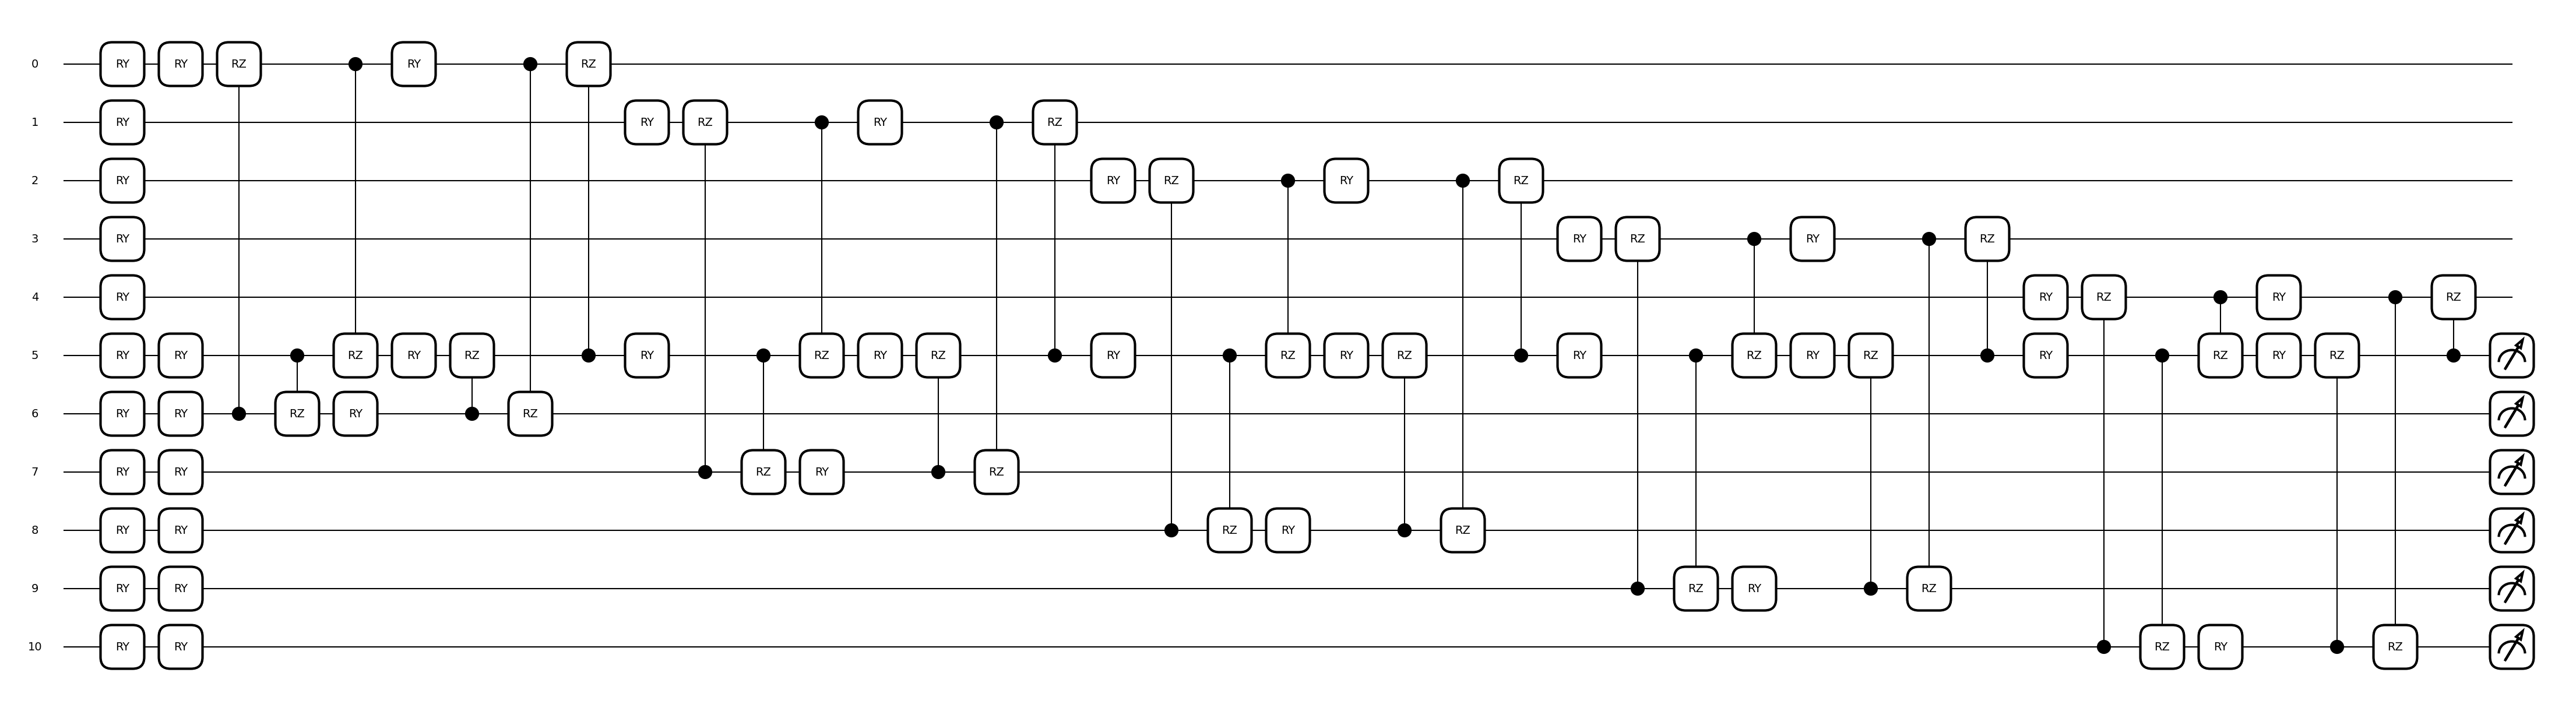

In [24]:
import matplotlib.pyplot as plt


fig, ax = qml.draw_mpl(qgnn_circuit)(inputs,weights)
plt.show()

# D2D Problems

In [25]:

import numpy as numpy

def generate_wGaussian(K, num_H, var_noise=1, Pmin=0, seed=2017):
    # H[:,j,k] channel from k tx to j rx
    print('Generate Data ... (seed = %d)' % seed)
    numpy.random.seed(seed)
    Pmax = 1
    Pini = Pmax*numpy.ones((num_H,K,1) )
    alpha = numpy.random.rand(num_H,K)
    # alpha = numpy.ones((num_H,K))
    #alpha = numpy.ones((num_H,K))
    fake_a = numpy.ones((num_H,K))
    #var_noise = 1
    X=numpy.zeros((K**2,num_H))
    Y=numpy.zeros((K,num_H))
    total_time = 0.0
    CH = 1/numpy.sqrt(2)*(numpy.random.randn(num_H,K,K)+1j*numpy.random.randn(num_H,K,K))
    H=abs(CH)
    Y = batch_WMMSE2(Pini,alpha,H,Pmax,var_noise)
    Y2 = batch_WMMSE2(Pini,fake_a,H,Pmax,var_noise)
    return H, Y, alpha, Y2

def batch_WMMSE2(p_int, alpha, H, Pmax, var_noise):
    N = p_int.shape[0]
    K = p_int.shape[1]
    vnew = 0
    b = numpy.sqrt(p_int)
    f = numpy.zeros((N,K,1) )
    w = numpy.zeros( (N,K,1) )


    mask = numpy.eye(K)
    rx_power = numpy.multiply(H, b)
    rx_power_s = numpy.square(rx_power)
    valid_rx_power = numpy.sum(numpy.multiply(rx_power, mask), 1)

    interference = numpy.sum(rx_power_s, 2) + var_noise
    f = numpy.divide(valid_rx_power,interference)
    w = 1/(1-numpy.multiply(f,valid_rx_power))
    #vnew = numpy.sum(numpy.log2(w),1)


    for ii in range(100):
        fp = numpy.expand_dims(f,1)
        rx_power = numpy.multiply(H.transpose(0,2,1), fp)
        valid_rx_power = numpy.sum(numpy.multiply(rx_power, mask), 1)
        bup = numpy.multiply(alpha,numpy.multiply(w,valid_rx_power))
        rx_power_s = numpy.square(rx_power)
        wp = numpy.expand_dims(w,1)
        alphap = numpy.expand_dims(alpha,1)
        bdown = numpy.sum(numpy.multiply(alphap,numpy.multiply(rx_power_s,wp)),2)
        btmp = bup/bdown
        b = numpy.minimum(btmp, numpy.ones((N,K) )*numpy.sqrt(Pmax)) + numpy.maximum(btmp, numpy.zeros((N,K) )) - btmp

        bp = numpy.expand_dims(b,1)
        rx_power = numpy.multiply(H, bp)
        rx_power_s = numpy.square(rx_power)
        valid_rx_power = numpy.sum(numpy.multiply(rx_power, mask), 1)
        interference = numpy.sum(rx_power_s, 2) + var_noise
        f = numpy.divide(valid_rx_power,interference)
        w = 1/(1-numpy.multiply(f,valid_rx_power))
    p_opt = numpy.square(b)
    return p_opt


def np_sum_rate(H,p,alpha,var_noise):
    H = numpy.expand_dims(H,axis=-1)
    K = H.shape[1]
    N = H.shape[-1]
    p = p.reshape((-1,K,1,N))
    rx_power = numpy.multiply(H, p)
    rx_power = numpy.sum(rx_power,axis=-1)
    rx_power = numpy.square(abs(rx_power))
    mask = numpy.eye(K)
    valid_rx_power = numpy.sum(numpy.multiply(rx_power, mask), axis=1)
    interference = numpy.sum(numpy.multiply(rx_power, 1 - mask), axis=1) + var_noise
    rate = numpy.log(1 + numpy.divide(valid_rx_power, interference))
    w_rate = numpy.multiply(alpha,rate)
    sum_rate = numpy.mean(numpy.sum(w_rate, axis=1))
    return sum_rate


def simple_greedy(X,AAA,label):

    n = X.shape[0]
    thd = int(numpy.sum(label)/n)
    Y = numpy.zeros((n,K))
    for ii in range(n):
        alpha = AAA[ii,:]
        H_diag = alpha * numpy.square(numpy.diag(X[ii,:,:]))
        xx = numpy.argsort(H_diag)[::-1]
        for jj in range(thd):
            Y[ii,xx[jj]] = 1
    return Y

def np_sum_rate_all(H,p,alpha,var_noise):
    H = numpy.expand_dims(H,axis=-1)
    K = H.shape[1]
    N = H.shape[-1]
    p = p.reshape((-1,K,1,N))
    rx_power = numpy.multiply(H, p)
    rx_power = numpy.sum(rx_power,axis=-1)
    rx_power = numpy.square(abs(rx_power))
    mask = numpy.eye(K)
    valid_rx_power = numpy.sum(numpy.multiply(rx_power, mask), axis=1)
    interference = numpy.sum(numpy.multiply(rx_power, 1 - mask), axis=1) + var_noise
    rate = numpy.log(1 + numpy.divide(valid_rx_power, interference))
    w_rate = numpy.multiply(alpha,rate)
    sum_rate = numpy.sum(w_rate, axis=1)
    return sum_rate

In [26]:
K = 3               # number of users
num_H = 1          # number of training samples
num_test = 1            # number of testing  samples
training_epochs = 20      # number of training epochs
trainseed = 13              # set random seed for training set
testseed = 13              # set random seed for test set
# print('Gaussian IC Case: K=%d, Total Samples: %d, Total Iterations: %d\n'%(K, num_H, training_epochs))
var_db = 10
var = 1/10**(var_db/10)
Xtrain, Ytrain, Atrain, wtime = generate_wGaussian(K, num_H, seed=trainseed, var_noise = var)
# X[:,l,k] from tx k to rx j, Y[:,l] power tx l
# A : weight
wmmse_sumrate = np_sum_rate_all(Xtrain,Ytrain,Atrain,var)[:,None]

X, Y, A, Y2 = generate_wGaussian(K, num_test, seed=testseed, var_noise = var)
bl_Y = simple_greedy(X,A,Y)
print('greedy:',np_sum_rate(X,bl_Y,A,var))

print('wmmse:',np_sum_rate(X.transpose(0,2,1),Y,A,var))
print('wmmse unweighted:',np_sum_rate(X.transpose(0,2,1),Y2,A,var))

# train_data_list = proc_data(Xtrain,Ytrain)
# test_data_list = proc_data(X,Y)

Generate Data ... (seed = 13)
Generate Data ... (seed = 13)
greedy: 2.7924752407098365
wmmse: 2.801933835716169
wmmse unweighted: 2.801933835716169


In [27]:
# H,p,alpha,var_noise = X.transpose(0,2,1),Y,A,var
# print(H)
# H = numpy.expand_dims(H,axis=-1)
# K = H.shape[1]
# N = H.shape[-1]
# p = p.reshape((-1,K,1,N))
# print(p)
# rx_power = numpy.multiply(H, p)
# rx_power = numpy.sum(rx_power,axis=-1)
# print(rx_power)
# rx_power = numpy.square(abs(rx_power))
# mask = numpy.eye(K)
# valid_rx_power = numpy.sum(numpy.multiply(rx_power, mask), axis=1)
# interference = numpy.sum(numpy.multiply(rx_power, 1 - mask), axis=1) + var_noise
# rate = numpy.log(1 + numpy.divide(valid_rx_power, interference))
# w_rate = numpy.multiply(alpha,rate)
# sum_rate = numpy.mean(numpy.sum(w_rate, axis=1))

In [28]:
from torch.utils.data import Dataset, DataLoader

class d2dDataset(Dataset):
    def __init__(self, num_samples, num_D2D, p_max, n0, seed=1309):
        self.num_samples = num_samples
        self.num_D2D = num_D2D
        self.p_max = p_max  # Transmit power
        self.n0 = n0  # Noise power
        self.seed = seed

        # Generate the dataset (graphs and labels)
        self.channels, self.w_sumrate, self.objs, self.labels = self.generate_data()

    def generate_data(self):
        channel_matrices, power_matrices, weight_matrices, _ = generate_wGaussian(self.num_D2D, self.num_samples, seed=self.seed, var_noise = self.n0)
        power_matrices = self.quantize_labels(power_matrices)
        wmmse_sumrate = np_sum_rate_all(channel_matrices,power_matrices,weight_matrices,self.n0)[:,None]
        print(f'Benchmark WMMSE: {np.mean(wmmse_sumrate)}')
        return channel_matrices.transpose(0,2,1), weight_matrices, wmmse_sumrate, power_matrices

    def quantize_labels(self, labels, num_levels=4):
        levels = np.linspace(0, 1, num_levels)

        # Quantize labels by finding the closest level
        quantized_labels = np.zeros_like(labels)
        for i in range(labels.shape[0]):  # Iterate over samples
            for j in range(labels.shape[1]):  # Iterate over D2D pairs
                quantized_labels[i, j] = levels[np.argmin(np.abs(levels - labels[i, j]))]

        return quantized_labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.channels[idx], self.w_sumrate[idx], self.objs[idx], self.labels[idx]

# Training and Testing

In [29]:
def preprocess_inputs(channel_matrices, weight_matrices):
    num_nodes = channel_matrices.shape[0]

    node_feat = torch.stack([
        torch.stack([channel_matrices[i, i], weight_matrices[i]])
        for i in range(num_nodes)
    ])

    edge_attr = []
    edge_index = []

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_attr.append(torch.tensor([channel_matrices[i, j], channel_matrices[j, i]]))
            edge_index.append((i, j))

    edge_attr = torch.stack(edge_attr)

    return node_feat, edge_attr, edge_index

In [30]:
import pickle
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

def train(model, train_loader, optimizer, setting='supervised'):
    model.train()
    total_loss = 0
    total_rate = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for channel_matrices, weight_sumrates, _, labels in train_loader:
        channel_matrices = channel_matrices[0].T.to(device).to(torch.float32)
        labels = labels[0].to(device).to(torch.float32)
        weight_sumrates = weight_sumrates[0].to(device).to(torch.float32)

        # original_channel = channel_matrices.clone()
        # channel_matrices = (channel_matrices - channel_matrices.min()) / (channel_matrices.max() - channel_matrices.min())

        optimizer.zero_grad()
        node_feat, edge_attr, edge_index = preprocess_inputs(channel_matrices, weight_sumrates)

        output = model(node_feat, edge_attr, edge_index).float()
        if setting == 'supervised':
            loss = criterion(output, labels)
        elif setting == 'unsupervised':
            loss = sum_weighted_rate(channel_matrices, output, weight_sumrates, var)
            loss = torch.neg(loss)

        loss.backward()
        optimizer.step()
        with torch.no_grad():
            power_new = output #quantize_output(output)
            sum_rate = sum_weighted_rate(channel_matrices, power_new, weight_sumrates, var)
        total_rate += sum_rate.item()
        total_loss += loss.item()

    return total_loss / len(train_loader), total_rate / len(train_loader)


def test(model, test_loader):
    model.eval()
    total_loss = 0
    total_rate = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for channel_matrices, weight_sumrates, _, labels in test_loader:
            channel_matrices = channel_matrices[0].T.to(device).to(torch.float32)
            labels = labels[0].to(device).to(torch.float32)
            weight_sumrates = weight_sumrates[0].to(device).to(torch.float32)
            # original_channel = channel_matrices.clone()
            # channel_matrices = (channel_matrices - channel_matrices.min()) / (channel_matrices.max() - channel_matrices.min())
            node_feat, edge_attr, edge_index = preprocess_inputs(channel_matrices, weight_sumrates)

            output = model(node_feat, edge_attr, edge_index).float()
            power_new = output #quantize_output(output)
            sum_rate = sum_weighted_rate(channel_matrices, power_new, weight_sumrates, var)
            total_rate += sum_rate.item()

    return total_rate / len(test_loader)


def quantize_output(output, num_levels=4):
    levels = torch.linspace(0, 1, steps=num_levels, device=output.device)
    # Find closest level for each output value
    quantized_output = torch.zeros_like(output)
    for i in range(output.shape[0]):
        quantized_output[i] = levels[torch.argmin(torch.abs(levels - output[i]))]
    return quantized_output


def sum_weighted_rate(h, p, w, n0):

    all_signal = torch.square(h * p.view(-1, 1))
    des_signal = torch.diag(all_signal)
    rx_signal = torch.sum(all_signal, dim=0)
    inteference = rx_signal - des_signal + n0

    sinr = des_signal/inteference
    w_sumrate = torch.log2(1 + sinr * w)
    return torch.sum(w_sumrate)

# Main

In [31]:
# Hyperparameters and setup
training_sam = 100
testing_sam = 50
num_nodes = 10  # Number of UEs (nodes)
p = 10  # Transmit power of each UE
I0 = 0.5  # Interference to all UEs
n0 = 1  # Noise power
var_db = 10
var = 1/10**(var_db/10)
num_edges = int(num_nodes * (num_nodes - 1)/2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [32]:
train_dataset = d2dDataset(num_samples=training_sam, num_D2D=num_nodes, p_max=p, n0=var, seed=1309)
test_dataset = d2dDataset(num_samples=testing_sam, num_D2D=num_nodes, p_max=p, n0=var, seed=1712)

Generate Data ... (seed = 1309)
Benchmark WMMSE: 2.4753837607947573
Generate Data ... (seed = 1712)
Benchmark WMMSE: 2.753019582103474


In [33]:
mode_num

13

In [34]:
setup_overlap = 1
if mode == 'strong':
    param_shape = {"weights": (num_layers, num_ent_lay, 3, 3)} # Strong
elif mode == 'basic':
    param_shape = {"weights": (num_layers, num_ent_lay, 3)}
elif mode == 'custom':
    if mode_num == 1:
        param_shape = {"weights": (num_layers, 3, 2)} # custom circuit 1
    elif mode_num == 13:
        param_shape = {"weights": (num_layers, 3, 4)} # circuit 13
print(param_shape)


{'weights': (1, 3, 4)}


## Star decomposition

In [35]:
import torch.optim.lr_scheduler as lr_scheduler

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# model_sup = QuantumGraphNetwork(graphlet_sise =num_nodes_model, overlap_size=3).to(device)
# param_shape = {"weights": (num_layers, num_ent_lay, 3, 3)}
# param_shape = {"weights": (num_layers, num_ent_lay, 3)}
model_star = QGNN_star(w_shapes=param_shape,
                 graphlet_size = num_nodes_model,
                 overlap_size=setup_overlap
                ).to(device)

optimizer_star = torch.optim.Adam(model_star.parameters(), lr=5e-2)
scheduler_star = lr_scheduler.StepLR(optimizer_star, step_size=1, gamma=0.9)


In [ ]:
training_sinr = []
testing_sinr = []
num_epochs = 10 # Number of epochs for training
for epoch in range(num_epochs):
    # Train the model
    avg_train_loss, avg_train_sinr = train(model_star, train_loader, optimizer_star, 'unsupervised')
    scheduler_star.step()
    avg_test_sinr = test(model_star, test_loader)
    training_sinr.append(avg_train_sinr)
    testing_sinr.append(avg_test_sinr)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {-avg_train_loss:.4f}, Training SINR: {training_sinr[-1]:.4f}, Testing SINR: {testing_sinr[-1]:.4f}")

In [ ]:
total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in train_loader:
    total_label += opt_sinr
    num_batch += 1
train_label = total_label/num_batch

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in test_loader:
    total_label += opt_sinr
    num_batch += 1
test_label = total_label/num_batch

In [ ]:
import matplotlib.pyplot as plt


plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_sinr, label='Training Sum Rate', marker='o', color='b')
plt.plot(range(1, num_epochs+1), testing_sinr, label='Testing Sum Rate', marker='s', color='r')
# plt.axhline(y=train_label, color='black', linestyle='-', label='Optimal SINR')
plt.axhline(y=train_label, color='black', linestyle='-', label='WMMSE')

plt.title('Unsupervised Setting')
plt.xlabel('Epoch')
plt.ylabel('SINR')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
eval_sam = 200
eval_dataset = d2dDataset(num_samples=eval_sam, num_D2D=num_nodes, p_max=p, n0=var, seed=303)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in eval_loader:
    total_label += opt_sinr
    num_batch += 1
eval_label = total_label/num_batch

# avg_eval_sinr = test(model_sup, eval_loader)
avg_eval_sinr_star = test(model_star, eval_loader)

In [ ]:
print(f'Average sum SINR by optimal algorithm: {eval_label.item():.4f}')
# print(f'Average sum SINR by sup-QGNN: {avg_eval_sinr:.4f} - {(avg_eval_sinr/eval_label.item() * 100):.2f}%')
print(f'Average sum SINR by unsup-QGNN: {avg_eval_sinr_star:.4f} - {(avg_eval_sinr_star/eval_label.item() * 100):.2f}%')

In [ ]:
torch.save({
    'model_state_dict': model_star.state_dict(),
    'optimizer_state_dict': optimizer_star.state_dict(),
    'scheduler_state_dict': scheduler_star.state_dict()
}, "qgnn_model_star.pth")

## Supervised

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# model_sup = QuantumGraphNetwork(graphlet_sise =num_nodes_model, overlap_size=3).to(device)

# param_shape = {"weights": (num_layers, num_ent_lay, 3)} # Basic
# param_shape = {"weights": (num_layers, 3, 2)} # custom circuit 1
# param_shape = {"weights": (num_layers, 3, 3)} # circuit 13

model_sup = QGNN(w_shapes=param_shape,
                 graphlet_size = num_nodes_model,
                 overlap_size=setup_overlap,
                ).to(device)

optimizer_sup = torch.optim.Adam(model_sup.parameters(), lr=1e-1)
scheduler_sup = lr_scheduler.StepLR(optimizer_sup, step_size=2, gamma=0.8)

In [ ]:
training_sinr = []
testing_sinr = []
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    # Train the model
    avg_train_loss, avg_train_sinr = train(model_sup, train_loader, optimizer_sup, 'supervised')
    scheduler_sup.step()
    avg_test_sinr = test(model_sup, test_loader)
    training_sinr.append(avg_train_sinr)
    testing_sinr.append(avg_test_sinr)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {avg_train_loss:.4f}, Training SINR: {training_sinr[-1]:.4f}, Testing SINR: {testing_sinr[-1]:.4f}")

In [ ]:
total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in train_loader:
    total_label += opt_sinr
    num_batch += 1
train_label = total_label/num_batch

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in test_loader:
    total_label += opt_sinr
    num_batch += 1
test_label = total_label/num_batch

In [ ]:
import matplotlib.pyplot as plt


plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_sinr, label='Training Sum Rate', marker='o', color='b')
plt.plot(range(1, num_epochs+1), testing_sinr, label='Testing Sum Rate', marker='s', color='r')
# plt.axhline(y=train_label, color='black', linestyle='-', label='Optimal SINR')
plt.axhline(y=train_label, color='black', linestyle='-', label='WMMSE')

plt.title('Supervised Training')
plt.xlabel('Epoch')
plt.ylabel('SINR')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)
plt.show()

## Unsupervised

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# model_sup = QuantumGraphNetwork(graphlet_sise =num_nodes_model, overlap_size=3).to(device)
# param_shape = {"weights": (num_layers, num_ent_lay, 3, 3)}
# param_shape = {"weights": (num_layers, num_ent_lay, 3)}
model_unsup = QGNN(w_shapes=param_shape,
                 graphlet_size = num_nodes_model,
                 overlap_size=setup_overlap
                ).to(device)

optimizer_unsup = torch.optim.Adam(model_unsup.parameters(), lr=1e-1)
scheduler_unsup = lr_scheduler.StepLR(optimizer_unsup, step_size=2, gamma=0.8)


In [ ]:
training_sinr = []
testing_sinr = []
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    # Train the model
    avg_train_loss, avg_train_sinr = train(model_unsup, train_loader, optimizer_unsup, 'unsupervised')
    scheduler_unsup.step()
    avg_test_sinr = test(model_unsup, test_loader)
    training_sinr.append(avg_train_sinr)
    testing_sinr.append(avg_test_sinr)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {-avg_train_loss:.4f}, Training SINR: {training_sinr[-1]:.4f}, Testing SINR: {testing_sinr[-1]:.4f}")

In [ ]:
total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in train_loader:
    total_label += opt_sinr
    num_batch += 1
train_label = total_label/num_batch

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in test_loader:
    total_label += opt_sinr
    num_batch += 1
test_label = total_label/num_batch

In [ ]:
import matplotlib.pyplot as plt


plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_sinr, label='Training Sum Rate', marker='o', color='b')
plt.plot(range(1, num_epochs+1), testing_sinr, label='Testing Sum Rate', marker='s', color='r')
# plt.axhline(y=train_label, color='black', linestyle='-', label='Optimal SINR')
plt.axhline(y=train_label, color='black', linestyle='-', label='WMMSE')

plt.title('Unsupervised Setting')
plt.xlabel('Epoch')
plt.ylabel('SINR')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)
plt.show()


## Evaluate the Model

In [ ]:
eval_sam = 300
eval_dataset = d2dDataset(num_samples=eval_sam, num_D2D=num_nodes, p_max=p, n0=var, seed=303)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

total_label = 0
num_batch = 0
for _, _, opt_sinr, _ in eval_loader:
    total_label += opt_sinr
    num_batch += 1
eval_label = total_label/num_batch

# avg_eval_sinr = test(model_sup, eval_loader)
avg_eval_sinr_unsup = test(model_unsup, eval_loader)

Generate Data ... (seed = 303)
Benchmark WMMSE: 2.3277710062689843


In [ ]:
print(f'Average sum SINR by optimal algorithm: {eval_label.item():.4f}')
# print(f'Average sum SINR by sup-QGNN: {avg_eval_sinr:.4f} - {(avg_eval_sinr/eval_label.item() * 100):.2f}%')
print(f'Average sum SINR by unsup-QGNN: {avg_eval_sinr_unsup:.4f} - {(avg_eval_sinr_unsup/eval_label.item() * 100):.2f}%')

Average sum SINR by optimal algorithm: 2.3278
Average sum SINR by unsup-QGNN: 2.1793 - 93.62%


In [ ]:
torch.save({
    'model_state_dict': model_unsup.state_dict(),
    'optimizer_state_dict': optimizer_unsup.state_dict(),
    'scheduler_state_dict': scheduler_unsup.state_dict()
}, "qgnn_model.pth")

In [ ]:
# # Load the checkpoint
# checkpoint = torch.load("qgnn_model_13_real.pth", map_location=device)

# # Load model, optimizer, and scheduler state dictionaries
# model_unsup.load_state_dict(checkpoint['model_state_dict'])
# optimizer_unsup.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler_unsup.load_state_dict(checkpoint['scheduler_state_dict'])

# print("Model, optimizer, and scheduler loaded successfully!")

In [ ]:
# Counter for cases where unsupervised QGNN outperforms the benchmark
better_unsup_count = 0
total_samples = 0

# Switch model to evaluation mode
model_unsup.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for channel_matrices, weight_sumrates, opt_sinr, _ in eval_loader:
        total_samples += 1

        # Move data to device
        channel_matrices = channel_matrices[0].T.to(device).to(torch.float32)
        weight_sumrates = weight_sumrates[0].to(device).to(torch.float32)
        opt_sinr = opt_sinr[0].to(device).to(torch.float32)  # Optimal SINR for comparison

        # Get prediction from unsupervised QGNN
        output = model_unsup(channel_matrices, weight_sumrates).float()
        power_new = output  # Use power allocation output
        sum_rate_unsup = sum_weighted_rate(channel_matrices, power_new, weight_sumrates, var)

        # Check if unsupervised QGNN is better than the optimal SINR
        if sum_rate_unsup.item() > opt_sinr.item():
            better_unsup_count += 1

# Compute percentage of cases where QGNN performed better
unsup_better_ratio = (better_unsup_count / total_samples) * 100

# Print results
print(f"QGNN-Unsupervised outperforms the optimal SINR in {better_unsup_count}/{total_samples} cases ({unsup_better_ratio:.2f}%).")


QGNN-Unsupervised outperforms the optimal SINR in 85/200 cases (42.50%).


# Other Testing

## New Model

In [ ]:
model = QGNN_star(w_shapes=param_shape,
                 graphlet_size = num_nodes_model,
                 overlap_size=setup_overlap
                ).to(device)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
input_layer = torch.nn.Linear(2, 1)

In [ ]:
for channel_matrices, weight_sumrates, _, labels in train_loader:
    channel_matrices = channel_matrices[0].T.to(device).to(torch.float32)
    labels = labels[0].to(device).to(torch.float32)
    weight_sumrates = weight_sumrates[0].to(device).to(torch.float32)
    break
channel_matrices = channel_matrices
weight_matrices = weight_sumrates

In [ ]:
print(f"channel_matrices: {channel_matrices.shape}")
print(f"weight_matrices: {weight_matrices.shape}")

channel_matrices: torch.Size([10, 10])
weight_matrices: torch.Size([10])


In [ ]:
def preprocess_inputs(channel_matrices, weight_matrices):
    num_nodes = channel_matrices.shape[0]

    node_feat = torch.stack([
        torch.stack([channel_matrices[i, i], weight_matrices[i]])
        for i in range(num_nodes)
    ])

    edge_attr = []
    edge_index = []

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_attr.append(torch.tensor([channel_matrices[i, j], channel_matrices[j, i]]))
            edge_index.append((i, j))

    edge_attr = torch.stack(edge_attr)

    return node_feat, edge_attr, edge_index

In [ ]:
node_feat, edge_attr, edge_index = preprocess_inputs(channel_matrices, weight_matrices)

In [ ]:
num_of_nodes = channel_matrices.shape[0]
all_feat = {}
for l in range(num_of_nodes):
    for k in range(l, num_of_nodes):
        if l != k:
            tmp = torch.tensor([channel_matrices[l, k], channel_matrices[k, l]])
        else:
            tmp = torch.tensor([channel_matrices[l, k], weight_matrices[l]])
        all_feat[f'{l}_{k}'] = input_layer(tmp).squeeze()

adj_mtx = full_adj_numpy = np.ones((num_of_nodes, num_of_nodes)) - np.eye(num_of_nodes)
graphlets = star_subgraph(adj_mtx, subgraph_size=5)

In [ ]:
graphlets

[[0, 8, 6, 2, 3],
 [1, 7, 9, 5, 4],
 [2, 0, 1, 9, 5],
 [3, 8, 1, 6, 0],
 [4, 9, 1, 2, 6],
 [5, 7, 8, 6, 1],
 [6, 0, 5, 4, 7],
 [7, 1, 5, 6, 8],
 [8, 0, 1, 7, 2],
 [9, 5, 7, 4, 2]]

## Other

In [ ]:
@qml.qnode(dev, interface='torch')
def qgnn_node(inputs, weights):
    """Quantum graph neural network circuit."""
    thetas = weights[:,:, 0].to(torch.cfloat)
    phis = weights[:,:, 1].to(torch.cfloat)
    adjacency_matrix, vertex_features = unpack_inputs(inputs)

    # Measure initial qubit states
    initial_states = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    print("Initial qubit states:", initial_states)  # Debugging

    q_edge_encoding(adjacency_matrix)
    q_vertex_encoding(vertex_features)

    for each_lay in range(num_layers):
        quantum_graph_conv_layer(thetas[each_lay], phis[each_lay], num_edges)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_edges,n_qubits)]

In [ ]:
setting = 'supervised'

In [ ]:
def check_initial_state():
    """Returns the initial state of all qubits before any operation."""
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Run the function and print initial qubit states
initial_states = check_initial_state()
print("Measured Initial Qubit States:", initial_states)

Measured Initial Qubit States: [expval(Z(0)), expval(Z(1)), expval(Z(2)), expval(Z(3)), expval(Z(4)), expval(Z(5)), expval(Z(6)), expval(Z(7)), expval(Z(8)), expval(Z(9))]


In [ ]:
training_sinr = []
testing_sinr = []
num_epochs = 6  # Number of epochs for training
for epoch in range(num_epochs):
    # Train the model
    avg_train_loss, avg_train_sinr = train(model_sup, train_loader, optimizer_sup, 'supervised')
    avg_test_sinr = test(model_sup, test_loader)
    training_sinr.append(avg_train_sinr)
    testing_sinr.append(avg_test_sinr)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {-avg_train_loss:.4f}, Training SINR: {training_sinr[-1]:.4f}, Testing SINR: {testing_sinr[-1]:.4f}")

Epoch 1/6, Training loss: -0.3033, Training SINR: 7.1267, Testing SINR: 7.2106
Epoch 2/6, Training loss: -0.3018, Training SINR: 7.2235, Testing SINR: 7.2804
Epoch 3/6, Training loss: -0.3006, Training SINR: 7.2902, Testing SINR: 7.4053
Epoch 4/6, Training loss: -0.2992, Training SINR: 7.2804, Testing SINR: 7.5406
Epoch 5/6, Training loss: -0.2982, Training SINR: 7.3817, Testing SINR: 7.5224
Epoch 6/6, Training loss: -0.2970, Training SINR: 7.4033, Testing SINR: 7.5678


## Graphlet Splitting

In [ ]:
import networkx as nx
import torch
import random
import matplotlib.pyplot as plt

def partition_graph_with_overlap(G, graphlet_size=4, overlap_nodes=1):

    nodes = list(G.nodes)
    graphlets = []

    # Shuffle nodes for randomness (optional)
    random.shuffle(nodes)

    i = 0
    while i <= len(nodes) - graphlet_size:
        sub_nodes = nodes[i:i + graphlet_size]
        subgraph = G.subgraph(sub_nodes).copy()
        graphlets.append(subgraph)

        i += (graphlet_size - overlap_nodes)

    return graphlets

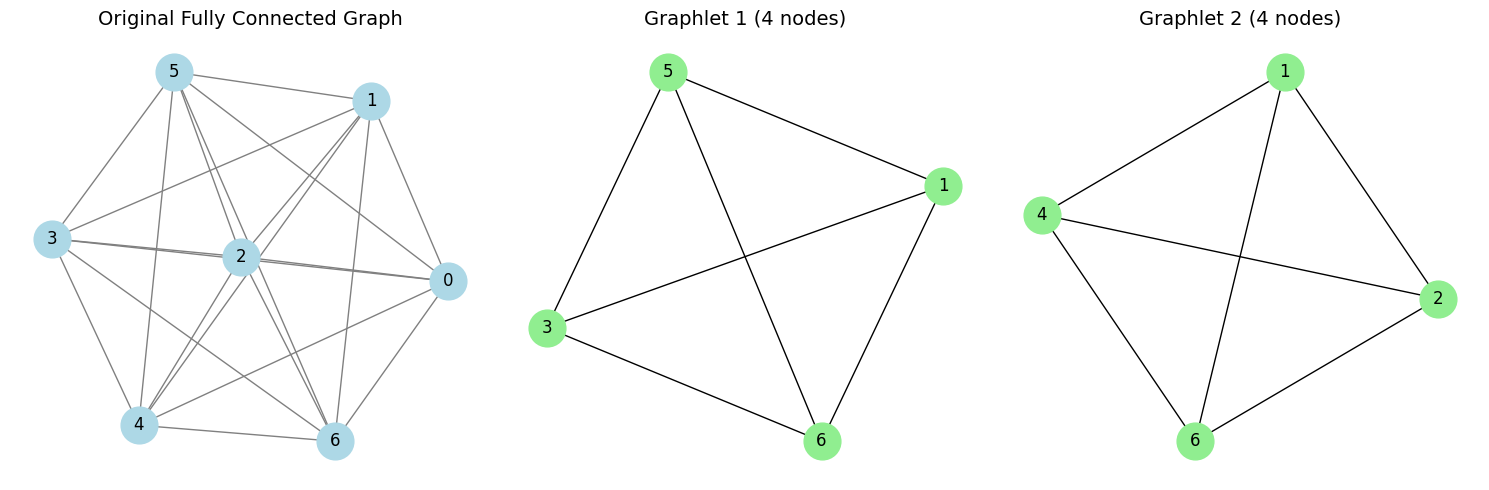

In [ ]:
# Create a fully connected graph with 6 nodes
N = 7
G = nx.complete_graph(N)

# Partition with graphlet size = 4 and overlap = 1
graphlet_size = 4
overlap_nodes = 2
graphlets = partition_graph_with_overlap(G, graphlet_size=graphlet_size, overlap_nodes=overlap_nodes)

# Visualization
num_graphlets = len(graphlets)
fig, axes = plt.subplots(1, num_graphlets + 1, figsize=(15, 5))

# Plot the original graph
axes[0].set_title("Original Fully Connected Graph", fontsize=14)
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=700, font_size=12, ax=axes[0])

# Plot each overlapping 4-node graphlet
for i in range(num_graphlets):
    subgraph = graphlets[i]
    axes[i + 1].set_title(f"Graphlet {i+1} ({len(subgraph.nodes)} nodes)", fontsize=14)
    nx.draw(subgraph, with_labels=True, node_color="lightgreen", edge_color="black", node_size=700, font_size=12, ax=axes[i + 1])

plt.tight_layout()
plt.show()

## Graphleting with the array

In [ ]:
import random

def graphleting(num_nodes, graphlet_size=4, overlap_nodes=1):
    graphlet_indices = []  # Store the indices of nodes in each graphlet

    # Generate indices for overlapping partitions
    indices = list(range(num_nodes))
    random.shuffle(indices)  # Shuffle nodes (optional)

    i = 0
    while i < num_nodes - (graphlet_size - 1):
        sub_indices = indices[i:i + graphlet_size]  # Select nodes for this graphlet
        graphlet_indices.append(sub_indices)  # Store node indices

        # Move forward while keeping overlap
        i += (graphlet_size - overlap_nodes)

    return graphlet_indices  # Return indices too

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CellularDatasetx(Dataset):
    def __init__(self, num_samples, num_nodes, p, I0, n0):
        self.num_samples = num_samples
        self.num_nodes = num_nodes
        self.p = p  # Transmit power
        self.I0 = I0  # Interference to all UEs
        self.n0 = n0  # Noise power

        # Generate the dataset (graphs and labels)
        self.graphs, self.sinr_max, self.label_alpha, self.graphlets = self.generate_data()

    def generate_data(self):
        graphs = []
        sinr_max = []
        label_alpha = []
        graphlets = []

        for _ in range(self.num_samples):
            h = np.random.rand(self.num_nodes)  # Channel gains for all users

            best_alpha, best_sinr = exhaustive_search_best_alpha(self.num_nodes, h, self.p, self.I0, self.n0)

            node_features = torch.tensor(h, dtype=torch.float64)
            graphlet_indices = graphleting(len(node_features), graphlet_size=graphlet_size, overlap_nodes=overlap_nodes)

            # Fully connected graph => adjacency vector with all ones (except diagonal)
            adjacency_vector = torch.ones(int(self.num_nodes * (self.num_nodes - 1) / 2))

            # Append the generated graph and its corresponding label (optimal alpha)
            graphs.append((adjacency_vector, node_features))
            sinr_max.append(torch.tensor(best_sinr, dtype=torch.float32))  # Binary transmission decisions
            label_alpha.append(torch.tensor(best_alpha, dtype=torch.float32))
            graphlets.append(graphlet_indices)

        return graphs, sinr_max, label_alpha, graphlets

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.graphs[idx], self.sinr_max[idx], self.label_alpha[idx], self.graphlets[idx]

In [ ]:
# Hyperparameters and setup
training_sam = 10
testing_sam = 10
num_nodes = 7  # Number of UEs (nodes)
p = 10  # Transmit power of each UE
I0 = 0.5  # Interference to all UEs
n0 = 1  # Noise power
num_edges = int(num_nodes * (num_nodes - 1)/2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = CellularDataset(training_sam, num_nodes, p, I0, n0)
test_dataset = CellularDatasetx(testing_sam, num_nodes, p, I0, n0)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model = QuantumGraphNetwork().to(device)

In [ ]:
model.train()
total_loss = 0
total_sinr = 0
for graph_data, _, labels in train_loader:
    adjacency_matrix, node_features = graph_data
    # print(adjacency_matrix)
    # print(node_features)
    # Send to device (GPU or CPU)
    adjacency_matrix = adjacency_matrix[0].to(device)
    node_features = node_features[0].to(device)
    labels = labels[0].to(device)

    # Forward pass
    output = model(node_features)

In [ ]:
output

{0: tensor(0.3868, dtype=torch.float64, grad_fn=<DivBackward0>),
 1: tensor(0.3914, dtype=torch.float64, grad_fn=<DivBackward0>),
 2: tensor(0.0879, dtype=torch.float64, grad_fn=<DivBackward0>),
 3: tensor(0.3637, dtype=torch.float64, grad_fn=<DivBackward0>),
 4: tensor(0.1717, dtype=torch.float64, grad_fn=<DivBackward0>),
 5: tensor(0.3500, dtype=torch.float64, grad_fn=<DivBackward0>),
 6: tensor(0.1097, dtype=torch.float64, grad_fn=<DivBackward0>)}

In [ ]:
graphlet_indices = graphleting(len(vertex_features), graphlet_size=4, overlap_nodes=1)
for each_graphlet in graphlet_indices:
    graphlet_features = vertex_features[each_graphlet]
    graphlet_size = graphlet_features.shape[0]
    adjacency_matrix = torch.ones(int(graphlet_size * (graphlet_size - 1) / 2)).to(device)
    inputs = torch.cat((adjacency_matrix, graphlet_features), dim=0)
    print(inputs)
    print()


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9717, 0.6658, 0.2962,
        0.9461], dtype=torch.float64)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9461, 0.9603, 0.2523,
        0.9987], dtype=torch.float64)


## Current working playground for training

In [ ]:
for eachSample in range(1):
    graph_datas, sinr_all, labels, graphlets = train_dataset[eachSample]
    _, all_feats = graph_datas
    num_of_nodes = all_feats.shape[0]
    feat_hist = {i: all_feats[i] for i in range(num_of_nodes)}
    for each_graphlet in graphlets:
        node_features = all_feats[each_graphlet].to(device)
        graphlet_size = node_features.shape[0]
        adjacency_matrix = torch.ones(int(graphlet_size * (graphlet_size - 1) / 2)).to(device)
        output = model(adjacency_matrix, node_features).float()

        label = labels[each_graphlet]
        loss = criterion(output, label)

In [ ]:
output

tensor([0.3762, 0.0000, 0.0000, 0.0000], grad_fn=<ToCopyBackward0>)

In [ ]:
num_of_nodes = vertex_features.shape[0]
feat_hist = {i: vertex_features[i] for i in range(num_of_nodes)}
feat_hist

{0: tensor(0.9717, dtype=torch.float64),
 1: tensor(0.9461, dtype=torch.float64),
 2: tensor(0.9603, dtype=torch.float64),
 3: tensor(0.2523, dtype=torch.float64),
 4: tensor(0.2962, dtype=torch.float64),
 5: tensor(0.9987, dtype=torch.float64),
 6: tensor(0.6658, dtype=torch.float64)}

In [ ]:
for idx, node in enumerate(each_graphlet):
    print(feat_hist[node])
    print(output[idx])

tensor(0.9461, dtype=torch.float64)
tensor(0.3762, grad_fn=<SelectBackward0>)
tensor(0.9603, dtype=torch.float64)
tensor(0., grad_fn=<SelectBackward0>)
tensor(0.2523, dtype=torch.float64)
tensor(0., grad_fn=<SelectBackward0>)
tensor(0.9987, dtype=torch.float64)
tensor(0., grad_fn=<SelectBackward0>)


## Testing new benchmark

In [ ]:
# Parameters
N = 10  # Number of UEs
p = 10  # Transmit power of each UE
I0 = 0.5  # Interference to all UEs
n0 = 1  # Noise power

# Random channel gains (h_n) for each UE
h = np.random.rand(N)


In [ ]:
import numpy
import gurobipy as gp
from gurobipy import GRB


num_random_restarts = 10  # Number of times to try with different random initializations

best_alpha = None
best_objVal = -np.inf

for restart in range(num_random_restarts):

    max_iter = 100
    epsilon = 1e-10
    sum_SINR_list = []
    # Step 1: Init value
    # alpha = np.ones(N)
    alpha = np.random.randint(0, 2, N)
    lambda_vals = calculate_lambda(alpha, h, p, I0, n0)
    objVal_old = np.infty
    # Iteration loop
    for iteration in range(max_iter):

        # Step 2: Solve optimization problem with Gurobi
        model = gp.Model("SINR_Optimization")
        model.setParam('OutputFlag', 0)
        model.setParam('OptimalityTol', 1e-9)  # Tighten optimality tolerance
        model.setParam('FeasibilityTol', 1e-9)  # Tighten feasibility tolerance
        alpha_vars = model.addVars(N, vtype=GRB.BINARY, name="alpha")

        # Add continuous auxiliary variables y_n
        y_vars = model.addVars(N, lb=0, name="y")

        # Add continuous variables z_n to represent sqrt(alpha_n)
        z_vars = model.addVars(N, lb=0, name="z")

        for n in range(N):
            model.addGenConstrPow(z_vars[n], alpha_vars[n], 0.5, name=f"sqrt_constr_{n}")

        objective = gp.LinExpr()
        for n in range(N):
            objective += (2 * lambda_vals[n] * alpha_vars[n] * np.sqrt(p * h[n])
            - lambda_vals[n] ** 2 * (gp.quicksum(alpha_vars[i] * I0 for i in range(N) if i != n) + n0))

        model.setObjective(objective, GRB.MAXIMIZE)
        model.optimize()

        # Step 3: Get optimized values
        alpha_new = np.array([alpha_vars[n].X for n in range(N)])
        lambda_vals_new = calculate_lambda(alpha_new, h, p, I0, n0)
        # objVal = model.ObjVal
        objVal = recalculate_objective(alpha_new, lambda_vals_new, h, p, I0, n0)


        # print(f'======== Iterations: {iteration + 1}')
        # print("Current alpha values:", alpha_new)
        # # print("Current lambda value values:", lambda_vals_new)
        # print("Current Objective Value:", objVal)

        # Step 4: Calculate the sum SINR for the current iteration and store it
        sum_SINR = calculate_sum_SINR(alpha_new, h, p, I0, n0)
        sum_SINR_list.append(sum_SINR)

        # Step 5: Check convergence based on auxiliary variables y
        if np.abs(objVal_old - objVal) < epsilon:
            # print(f"Converged after {iteration+1} iterations.")
            break

        # Update alpha and y for the next iteration
        alpha = alpha_new
        lambda_vals = lambda_vals_new
        objVal_old = objVal

        if objVal > best_objVal:
            best_alpha = alpha_new
            best_objVal = objVal
            best_sum_list = sum_SINR_list

# Output the final solution
print("Optimal alpha values:", best_alpha)
print("Maximum sum SINR Value:", best_sum_list[-1])


Optimal alpha values: [1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Maximum sum SINR Value: 11.64048597813902


In [ ]:
best_a, best_s = frac_prog(N, h, p, I0, n0)
print(best_a, best_s)


[1. 1. 0. 0. 1. 0. 1. 0. 0. 0.] 11.551852089237313
